In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip3 install imutils
!pip3 install torchsummary
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import imutils
import cv2
from matplotlib import pyplot as plt
import glob

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=f793870b86c176941c3d6db59e6809f5e16a5818ad0a430981ccbe16b6eaf932
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
train_img_list = glob.glob("../input/fingers/train/*.png")
test_img_list = glob.glob("../input/fingers/test/*.png")
print(len(train_img_list),
     len(test_img_list), sep = '\n')

18000
3600


(128, 128, 3)


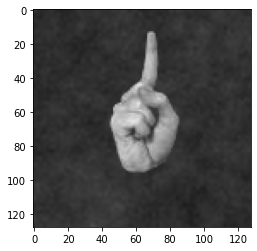

In [3]:
import numpy as np
im = cv2.imread(train_img_list[100])
print(im.shape)
plt.imshow(im)
plt.show()

(128, 128, 3)


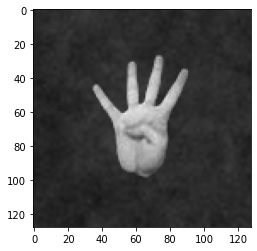

In [4]:
import numpy as np
im = cv2.imread(train_img_list[10])
print(im.shape)
plt.imshow(im)
plt.show()

(128, 128, 3)


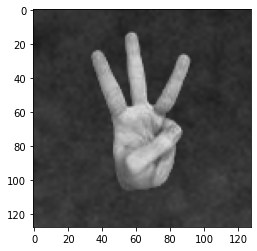

In [5]:
import numpy as np
im = cv2.imread(train_img_list[50])
print(im.shape)
plt.imshow(im)
plt.show()

(128, 128, 3)


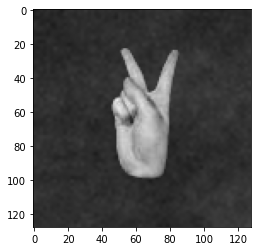

In [6]:
import numpy as np
im = cv2.imread(train_img_list[110])
print(im.shape)
plt.imshow(im)
plt.show()

In [7]:
train_transforms = transforms.Compose([
    
    # we resize the pictures
    transforms.Resize((128,128)),
#     transforms.RandomCrop(128),
#     transforms.RandomRotation(12),
#     transforms.RandomHorizontalFlip(),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transforms = transforms.Compose([
    
    # we resize the pictures
    transforms.Resize((128,128)),
   # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
        

In [14]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class Cdataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list=image_list
#         print(self.image_list)
        self.transforms=transforms
#         print(self.transforms)
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        single_image_path = self.image_list[index]
        im_as_im = Image.open(single_image_path)
        if self.transforms:
            im_as_im=self.transforms(im_as_im)
        im_as_np = np.asarray(im_as_im)/255
        im_as_np = np.expand_dims(im_as_np, 0)
        im_as_ten = torch.from_numpy(im_as_np).float()
        class_indicator_location = single_image_path.rfind('_')
        label = int(single_image_path[class_indicator_location+1:class_indicator_location+2])
        return (im_as_ten, label)

In [15]:
train_set=Cdataset(train_img_list, transforms = None)
test_set=Cdataset(test_img_list, transforms = None)

In [16]:
for images, labels in train_set:
    print(images.shape,labels)
    break


torch.Size([1, 128, 128]) 4


In [17]:
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

val_data_loader  = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

In [18]:
for images, labels in train_data_loader:
    print(images.shape)
    break

torch.Size([128, 1, 128, 128])


In [19]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x128x3 image tensor)
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        # convolutional layer (sees 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16,32, 3, padding=1)
        # convolutional layer (sees 32x32x32 tensor)
        self.conv3 = nn.Conv2d( 32,64, 3, padding=1)
        # convolutional layer (sees 16x16x64 tensor)
        #self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (256* 8* 8 -> )
        self.fc1 = nn.Linear(256 * 8*8, 500)
        
        self.fc2 = nn.Linear(500, 6)
#         self.fc2 = nn.Linear(8000, 6000)
#         self.fc3 = nn.Linear(6000, 5000)
#         self.fc4 = nn.Linear(5000, 4000)
#         self.fc5 = nn.Linear(4000, 3000)
                            
#         self.fc6 = nn.Linear(3000,2000)
#         self.fc7 = nn.Linear(2000, 1000)
#         self.fc8 = nn.Linear(1000, 100)
#         self.fc9 = nn.Linear(100, 6)
        
        
                
        
        
        
        #dropout layer (p=0.30)
        self.dropout = nn.Dropout(0.20)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        # flatten image input
        x = x.view(-1, 256*8* 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
      
        x = self.fc2(x)
     
       
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [21]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(),lr=0.00001)

In [23]:
n_epochs = 15


train,test=[],[]
for i in range(1, n_epochs+1):

    # keep track of training
    
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, label in train_data_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, label = images.cuda(), label.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
    
        with torch.no_grad():
            model.eval()
            for images,labels in val_data_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)


                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals = top_class ==labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        train.append(train_loss/len(train_data_loader))
        test.append(test_loss/len(val_data_loader))

        print("epoch: {}/{}..".format(i, n_epochs),
                 "train loss: {:.3f}..".format(train_loss/len(train_data_loader)),
                  "test loss: {:.3f}".format(test_loss/len(val_data_loader)),
                  "test acc: {:.3f}".format(accuracy/len(val_data_loader)))

epoch: 1/15.. train loss: 0.115.. test loss: 0.089 test acc: 0.975
epoch: 2/15.. train loss: 0.101.. test loss: 0.076 test acc: 0.978
epoch: 3/15.. train loss: 0.091.. test loss: 0.078 test acc: 0.980
epoch: 4/15.. train loss: 0.082.. test loss: 0.060 test acc: 0.981
epoch: 5/15.. train loss: 0.073.. test loss: 0.054 test acc: 0.985
epoch: 6/15.. train loss: 0.067.. test loss: 0.050 test acc: 0.989
epoch: 7/15.. train loss: 0.060.. test loss: 0.044 test acc: 0.988
epoch: 8/15.. train loss: 0.053.. test loss: 0.041 test acc: 0.989
epoch: 9/15.. train loss: 0.049.. test loss: 0.043 test acc: 0.989
epoch: 10/15.. train loss: 0.044.. test loss: 0.038 test acc: 0.993
epoch: 11/15.. train loss: 0.039.. test loss: 0.033 test acc: 0.992
epoch: 12/15.. train loss: 0.038.. test loss: 0.036 test acc: 0.992
epoch: 13/15.. train loss: 0.034.. test loss: 0.033 test acc: 0.993
epoch: 14/15.. train loss: 0.032.. test loss: 0.027 test acc: 0.994
epoch: 15/15.. train loss: 0.028.. test loss: 0.024 test 

In [81]:
checkpoint = {'model': Net(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [82]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [89]:
model = load_checkpoint('checkpoint.pth')
model=model.cuda()

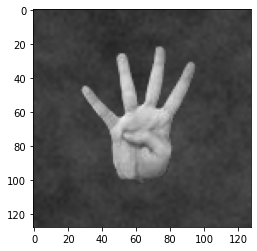

In [112]:
im = cv2.imread("../input/fingers/test/0062b79f-8fa4-4bbe-835c-a4811596bc84_4R.png")
plt.imshow(im)

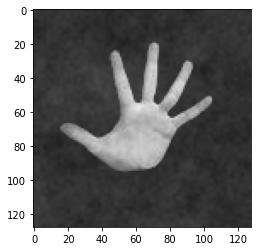

In [119]:
im2 = cv2.imread("../input/fingers/test/00ea59eb-7901-4268-95b2-f3c681a3b1aa_5L.png")
plt.imshow(im2)

In [120]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [114]:
ROI = cv2.resize(im,(128,128))
ROI = transform(ROI)
ROI = torch.tensor(ROI)
ROI = torch.unsqueeze(ROI, 1)
ROI = ROI.float()
ROI=ROI.cuda()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
ROI2 = cv2.resize(im2,(128,128))
ROI2 = transform(ROI2)
ROI2 = torch.tensor(ROI2)
ROI2 = torch.unsqueeze(ROI2, 1)
ROI2 = ROI2.float()
ROI2=ROI2.cuda()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [118]:
outputs=model(ROI)
_,pred = torch.max(outputs.data,1)
print(pred[0])

tensor(4, device='cuda:0')


In [123]:
outputs=model(ROI2)
_,pred = torch.max(outputs.data,1)
print(pred[0])

tensor(5, device='cuda:0')
